In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np 

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
#creating a variable to do feature engineering for both train and test set at the same time
data = [train, test]

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#determining whether there is any missing data before I begin feature engineering
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [7]:

#Passengir ID is unique to each person, so irrelevant for the algorithm, Ticket also appears unique, as does cabin, therefore I will drop them all
dropped = ['Ticket', 'Cabin']
for i in data:
    i.drop(columns = dropped, inplace = True)

In [8]:
#every name appears to have a title in front of it, while the names are unique there's a chance that the prefix could provide insights
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
for i in data:
    i['Title'] = i['Name'].map(lambda x: get_title(x))

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [10]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Capt              1
Don               1
Lady              1
Jonkheer          1
Sir               1
Ms                1
Mme               1
the Countess      1
Name: Title, dtype: int64

In [11]:
#For a large portion of these titles theres only one in the category, in order to get value I'll combine them into a single feature called Rare
def replace_title(Title):
    if Title in ['Don','Capt','Lady','Mme','Jonkheer','Sir','the Countess','Ms', 'Major','Col','Mlle']:
        return 'rare'
    else:
        return Title
for i in data:
    i['Title'] = i['Title'].apply(replace_title)

In [12]:
train['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
rare       14
Dr          7
Rev         6
Name: Title, dtype: int64

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 32.7+ KB


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


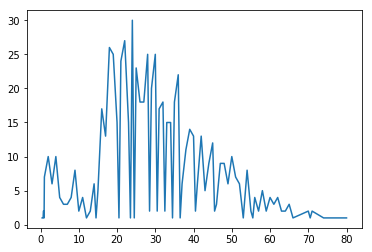

In [15]:
#I'm going to graph the distribution for the columns with missing values in order to determine which values are best to fill in
train.Age.value_counts().sort_index().plot.line()

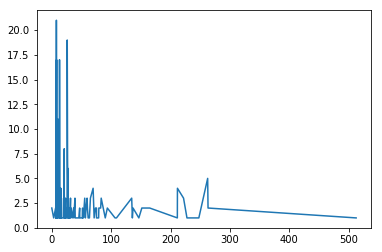

In [16]:
test.Fare.value_counts().sort_index().plot.line()

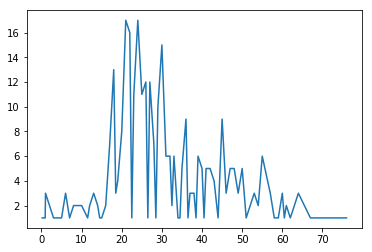

In [17]:
test.Age.value_counts().sort_index().plot.line()

In [18]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

As we can see, 4 columns have missing values in either the train or test set. Since these coloumns may help our algorithm improve in accuracy, I don't want to just delete the missing data, instead I'll fill the missing columns with an appropriate value, so as to maintain the value of the data provided. For Embarked, there appears to be only 2 values missing, and only 3 categories of data. Moreover, the vast majority of the passengers appear to have embarked on dock S, making it an easy choice to use the mode, to fill the missing 2 values. For the Age category of the training and test set, the graph shows a few outliers at high ages (60s - 80s) which may skew the mean, so I will fill the missing values with the median. Fare also seems to have some outliers at almost 500 while the majority of passengers paid between 0-100 dollars. For this reason, I'll fill the missing Fare values with the median as well. 

In [19]:
train['Embarked'].fillna(train['Embarked'].mode(), inplace = True)
train['Age'].fillna(train['Age'].median() ,inplace = True)
test['Fare'].fillna(test['Fare'].median(), inplace = True)
test['Age'].fillna(test['Age'].median(), inplace = True)


In [20]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null obje

Now that all of the columns contain full data sets I'm going to add a few engineered values to the dataset in order to hopefully improve my algorithm. The first I'll add, (other than title which was already added), is Family size (famsize) which is simply done by adding the number of siblings (SipSp) and Parents/ Children (Parch). I'm doing this based on an intuition that people are probably going to look after family members in the event of catastrophe and therefore family units will likely share similar chances of survival. Also, I would assume that larger families probably have difficulty finding all of their members in the event of a crash and have lower survival chances.

In [21]:
for i in data:
    i['famsize'] = i['SibSp'] + i['Parch'] + 1

Now I'm going to alter my features into numeric values to make the algorithms I'm using work easier.

In [22]:
def replace_sex(Sex):
    if Sex == 'male':
        return 0
    else:
        return 1
def replace_Embarked(embarked):
    if embarked == 'S':
        return 0
    elif embarked == 'C':
        return 1
    else:
        return 2
def replace_title(Title):
    if Title == 'rare':
        return 0
    elif Title == 'Mr':
        return 1
    elif Title == 'Mrs':
        return 2
    elif Title == 'Miss':
        return 3
    elif Title == 'Master':
        return 4
    elif Title == 'Dr':
        return 5
    else:
        return 6
for i in data:
    i['Sex'] = i['Sex'].apply(replace_sex)
    i['Embarked'] = i['Embarked'].apply(replace_Embarked)
    i['Title'] = i['Title'].apply(replace_title)
    i.drop(columns = ['Name'], inplace = True)
    
    

Now I'm going to split my data into a train and test set,  build a few models and check the cross validation score on them. 

In [23]:
y = train.Survived
x = train.drop('Survived', axis =1)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int64
Title          891 non-null int64
famsize        891 non-null int64
dtypes: float64(2), int64(9)
memory usage: 76.6 KB


In [25]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
XGB_model = XGBRegressor(objective = 'binary:logistic')
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(random_state=1)
train_x ,val_x, train_y, val_y = train_test_split(x,y, random_state = 1)
param = {'objective': 'reg:logistic'}
XGB_model.fit(train_x, train_y, early_stopping_rounds = 5, eval_set= [(val_x, val_y)], verbose=False)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
prediction = XGB_model.predict(val_x)
for i in range(len(prediction)):
    if i > .5:
        prediction[i] = 1
    else:
        prediction[i] = 0
from sklearn.metrics import mean_absolute_error
print('The mean absolute error is ' + str(mean_absolute_error(prediction, val_y)))

The mean absolute error is 0.57847533632287


In [27]:
#subbmitting predictions
Test_prediction = XGB_model.predict(test)
for i in range(len(Test_prediction)):
    if i > .7:
        Test_prediction[i] = 1
    else:
        Test_prediction[i] = 0
Test_prediction = Test_prediction.astype(int)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived' : Test_prediction })
output.to_csv('output.csv', index = False)